### Preparing dataset

In [49]:
variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    'control_gc_l_mean':'control volume',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'compo_frac':'composites fraction',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

In [50]:
import numpy as np
import pandas as pd
import sklearn 
import scipy
import geopandas as gpd

import datetime
import matplotlib.pylab as plt
import wastewater as ww
from wastewater.ml_utils import Dataset, RandomIntercepts, RandomEffects

In [76]:
# CIS Data
df_cis = ww.load_cis(daily=False).rename(columns={'CIS.name':"CIS20CD"})
df_cis_interpolated = ww.load_cis(daily=True, kind='linear').rename(columns={'CIS.name':"CIS20CD"})

# Preprocess WW data
df_ww = ww.read_ww()
df_ww.to_csv(f'{ww.data_dir}/raw_data_1_dec21.csv')      # example saving to data_dir
df_ww = ww.drop_wrong_dates(df_ww)
df_ww.to_csv(f'{ww.data_dir}/raw_data_2_dec21.csv')      # example saving to data_dir
df_ww = ww.select_specific_sites(df_ww)
df_ww.to_csv(f'{ww.data_dir}/raw_data_3_dec21.csv') # example saving to data_dir
df_ww = ww.select_sites_sampled_before(df_ww, '2021-01-01')
df_ww.to_csv(f'{ww.data_dir}/raw_data_4_dec21.csv') # example saving to data_dir
df_ww =  df_ww.merge(ww.read_sites()[['ww_site_code', 'catchment_population_ons_mid_2019', 'ww_catchment_code']])
df_ww.to_csv(f'{ww.data_dir}/raw_data_5_dec21.csv')
df_ww = df_ww.drop_duplicates(subset=['date_sample_collected', 'ww_site_code'])
df_ww.to_csv(f'{ww.data_dir}/raw_data_6_dec21.csv') 
# it would be preferable here to change the calculation of SARS-CoV-2 gc/l for those without replicate data
df_ww = ww.replace_loq_lod(df_ww, 133, 1333)
df_ww.loc[df_ww.ophosph_mg_l==-3, 'ophosph_mg_l'] = np.nan
df_ww = ww.add_new_ww_features(df_ww, reception_delay=True)
df_ww.to_csv(f'{ww.data_dir}/raw_data_7_dec21.csv') # example saving to data_dir



/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_cis.py:19: UserWarning: Data not yet ingested properly, please change the link to ingested dataset as soon as possible.
  warnings.warn('Data not yet ingested properly, please change the link to ingested dataset as soon as possible.')
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_cis.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_cis = df_cis.drop(df_cis.columns[0], 1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_cis.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_cis = df_cis.drop(['CIS.name', 'RGN19CD'],1).merge(df_cis[['cis_num', 'CIS.name', 'RGN19CD']].drop_duplicates().dropna())


Loading latest flow normalisation file: 20220401_EXPORT_SARS_COV2_FLOW_NORMALISATION.csv
Loading latest anomaly file: 20211018_EXPORT_SARS_COV2_CONCENTRATION_ANOMALY.csv
Missing values (-2 convention) have been replaced by nan
Samples to be rerun (-1 convention) have been replaced by nan
156 samples with wrong or missing dates (date_sample_collected) have been removed.
Selected 311 sites after filter on SEWAGE TREATMENT PLANT (site_type)
Selected 306 sites after filter on UK* codes
Selected 45 sites with first sample before 2021-01-01
LOD ([-4]) and LOQ ([-3, 0]) codes for ['flow_normalised_sars_cov2_gc_l_mean', 'sars_cov2_gc_l_mean'] have been replaced by LOD/2 and LOQ/2 respectively, using default values of LOD=133 and LOQ=1333 where missing in data.


/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/preprocessing.py:476: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  reception_time = pd.to_datetime(df_ww.time_sample_received.astype(str).str.pad(4, fillchar='0'), format='%H%M')- pd.datetime(1900,1,1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/preprocessing.py:477: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  collection_time = pd.to_datetime(df_ww.time_sample_collected.astype(str).str.pad(4, fillchar='0'), format='%H%M')- pd.datetime(1900,1,1)


In [77]:
# check whether replicate data pre-freb 2021 are loaded in
# below doesn't 'quite' get to it, but ~10% samples are with NAs, so that's ok
df_ww.head()
# list(df_ww.columns)
# 'raw_ansis_sars_repc_1',
# 'raw_ansis_sars_repc_2',
print(df_ww['raw_ansis_sars_repc_1'].describe())
nas1 = df_ww['raw_ansis_sars_repc_1'].isna().sum()
nas2 = df_ww['raw_ansis_sars_repc_2'].isna().sum()
rows = len(df_ww)
print(rows)
print('first replicate = ',nas1,' and ', round(100*(nas1/rows),2),'%')
print('second replicate = ',nas2,' and ', round(100*(nas2/rows),2),'%')

count    13090.000000
mean        65.577188
std        211.495841
min         -4.000000
25%         -3.000000
50%          9.213000
75%         41.341500
max       5059.119141
Name: raw_ansis_sars_repc_1, dtype: float64
14703
first replicate =  1613  and  10.97 %
second replicate =  1613  and  10.97 %


In [78]:
# add in year of collection from date
df_ww['year_coll'] = pd.DatetimeIndex(df_ww['date_sample_collected']).year
df_ww['rep1na'] = df_ww['raw_ansis_sars_repc_1'].isna()
df_ww['rep2na'] = df_ww['raw_ansis_sars_repc_2'].isna()
# create a table of observations
#print(df_ww['year_coll'].value_counts())
#print(df_ww['rep1na'].value_counts())
# to have NAs by year of collection I think I need to..
# - create a variable 0/1 of whether replicate is NA or not
# - create a table = df_ww.groupby('year_coll','is_na').size()
table = df_ww.groupby(['year_coll','rep1na']).size()
print(table)

year_coll  rep1na
2020       False     3376
           True       745
2021       False     7712
           True       803
2022       False     2002
           True        65
dtype: int64


In [79]:
# check how the mean value s calculated, and update if it isn't correct.
# raw_ansis_sars_repc_mean
df_ww['raw_ansis_sars_repc_mean_v2'] = (df_ww['raw_ansis_sars_repc_1'] + df_ww['raw_ansis_sars_repc_2'])/2
# need to select obs where only 1 rep is available, and update
 
def my_repfun (var1,var2,var3):
    df_ww[var3] = np.where((df_ww[var1]<0), df_ww[var2], (df_ww[var1]+df_ww[var2])/2) # if values of var1 <0, use var2 only 
    df_ww[var3] = np.where((df_ww[var2]<0), df_ww[var1], df_ww[var3]) # if values of var2 <0, use var3 only, now that we have made it 
    df_ww[var3] = np.where((df_ww[var1].isna()), df_ww[var2], df_ww[var3]) # if values of var2 <0, use var3 only, now that we have made it 
    df_ww[var3] = np.where((df_ww[var2].isna()), df_ww[var1], df_ww[var3]) # if values of var2 <0, use var3 only, now that we have made it 
    return df_ww

df_ww = my_repfun('raw_ansis_sars_repc_1','raw_ansis_sars_repc_2','raw_ansis_sars_repc_mean_v2')
df_ww['repc_mean_check'] = df_ww['raw_ansis_sars_repc_mean'] - df_ww['raw_ansis_sars_repc_mean_v2']
print(df_ww['repc_mean_check'].describe())
tmp = sum(df_ww['repc_mean_check']!=0)
print('This number of values are incorrectly calculated',tmp,'and percentage',100*(tmp/rows))

# well ... this hasn't been corrected!

count    1.308800e+04
mean    -3.591783e-01
std      1.499844e+00
min     -2.813997e+01
25%     -9.536743e-07
50%      0.000000e+00
75%      0.000000e+00
max      2.845380e+01
Name: repc_mean_check, dtype: float64
This number of values are incorrectly calculated 9443 and percentage 64.22498809766715


count    4863.000000
mean      199.789809
std       267.434127
min      -222.166667
25%       133.333301
50%       133.333333
75%       133.333354
max      1333.343318
Name: sars_c, dtype: float64
count    4.863000e+03
mean     1.986251e+04
std      4.501435e+04
min      7.334348e-07
25%      3.317594e+02
50%      4.905575e+03
75%      1.821719e+04
max      7.905188e+05
Name: sars_cov2_gc_l_mean_v2, dtype: float64
count    4866.000000
mean      133.716820
std       328.735897
min        -4.000000
25%         0.590000
50%        20.449941
75%       111.495934
max      5928.890381
Name: raw_ansis_sars_repc_mean_v2, dtype: float64
[-3.0, 0.0004200779949314892, 0.0008858250148477935, 0.0030471610371023, 0.003753105007490337, 0.008254924789071, 0.01345393131487065, 0.018377894768491367, 0.0199999995529651]


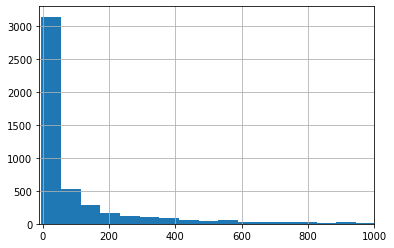

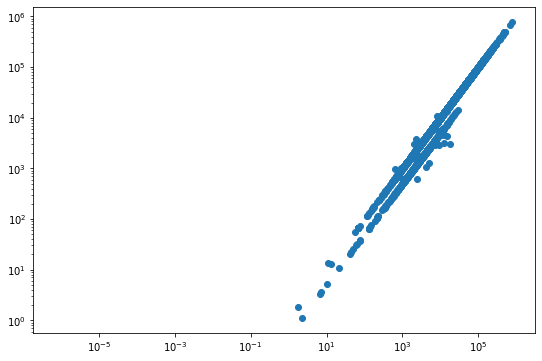

In [108]:
# correct the sars_cov2_gc_l_mean here..
df_ww['sars_c'] = df_ww['sars_cov2_gc_l_mean']/df_ww['raw_ansis_sars_repc_mean']
df_ww['sars_cov2_gc_l_mean_v2'] = df_ww['raw_ansis_sars_repc_mean_v2']*df_ww['sars_c']
# scatter plot

print(df_ww['sars_c'].describe())

print(df_ww['sars_cov2_gc_l_mean_v2'].describe())

print(df_ww['raw_ansis_sars_repc_mean_v2'].describe())

print(sorted(df_ww['raw_ansis_sars_repc_mean_v2'].unique())[1:10])

hist = df_ww['raw_ansis_sars_repc_mean_v2'].hist(bins=100)
hist.set_xlim(-10,1000)

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df_ww['sars_cov2_gc_l_mean_v2'],df_ww['sars_cov2_gc_l_mean'])
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(f'{ww.data_dir}/check_gc_l.png')



In [84]:
# re-define the gc_cl here
df_ww['sars_cov2_gc_l_mean'] = df_ww['sars_cov2_gc_l_mean_v2']  

## Generate summary stats for the variables here 
This is before any aggregation needed to relate to CIS

In [111]:
# summary stats, andchecking that specific stats have been generated correctly.
# included % missing
#print(df_ww.columns.values)

#df_ww['raw_ansis_sars_repc_std'] = np.std(df_ww['raw_ansis_sars_repc_1','raw_ansis_sars_repc_2'])
def my_stdfun (var1,var2):
    tmp1 = (df_ww[var1] + df_ww[var2])/2  # mean
    tmp2 = pow((pow((tmp1-df_ww[var1]),2) + pow((tmp1-df_ww[var2]),2))/2,0.5) # sd
    return tmp2

df_ww['raw_ansis_sars_repc_std'] = my_stdfun('raw_ansis_sars_repc_1','raw_ansis_sars_repc_2')

df_ww['sars_below_lod'] = np.where(df_ww['sars_cov2_gc_l_mean']<133,1,0)
df_ww['sars_below_loq'] = np.where(df_ww['sars_cov2_gc_l_mean']<1333,1,0)
df_ww['grab_compo_boo'] = np.where(df_ww['grab_compo_ind']=='Composite',1,0)

#df_ww['grab_compo_boo'].describe()

cols = ['sars_cov2_gc_l_mean','raw_ansis_sars_repc_std',
        'raw_ansis_sars_repc_mean_v2',
        'sars_below_lod','sars_below_loq',
        'reac_vol_control',
       'sample_ph_pre_ansis','ammonia_mg_l',
       'ophosph_mg_l','suspended_solids_mg_l',
        'reception_delay',
        'grab_compo_boo'
        
#         ,
#        'time_sample_collected'
       ]

def my_isnafun (var1):
    df_ww[var1] = df_ww[var1].replace('nan',np.NaN)
    tmp2 = df[var1].isnull()
    tmp3 = tmp2.mean()
    return tmp3

# out = []
# for var in cols[0:9]:
#     my_isnafun(var)
    
# for var in cols[0:10]:
#     out.append(df_ww[var].isnull().mean())

# print(out)


In [112]:
# check we have the right time period...
fdate = '2020-07-01'
ldate = '2021-03-31'

df_ww = df_ww.loc[(df_ww['date_sample_collected'] > fdate) & 
                   (df_ww['date_sample_collected'] < ldate)] 

t2 = df_ww['date_sample_collected'].describe()
print(t2)

t3 = df_ww['ww_site_code'].unique()
print('Number of unique sites = ',len(t3))

print('Number of raw obs = ',df_ww.shape)

out = df_ww['sars_cov2_gc_l_mean'].isnull().sum()
print('Null values in gc/l = ',out)

df_wwdp = df_ww.dropna(subset=['sars_cov2_gc_l_mean'])

#print(df_ww['sars_cov2_gc_l_mean'].describe())
print(df_wwdp['sars_cov2_gc_l_mean'].describe())

t1 = df_wwdp[cols].describe()
# #t1.append(out)
print(t1)

# ** so if there is NA in the gc/l these obs should really be removed.
# 4863 of the 6228 are NA? 


#t2 = t1.append(out)
#print(t2)

# write to file
t1.to_csv(f'{ww.data_dir}/data_describe_mar22.csv') 



count                    6228
unique                    193
top       2020-10-30 00:00:00
freq                       45
first     2020-07-06 00:00:00
last      2021-03-30 00:00:00
Name: date_sample_collected, dtype: object
Number of unique sites =  45
Number of raw obs =  (6228, 110)
Null values in gc/l =  1365
count      4863.000000
mean      19625.938574
std       45087.294800
min          -6.623212
25%         235.191177
50%        4371.329840
75%       18023.976176
max      790518.720052
Name: sars_cov2_gc_l_mean, dtype: float64
       sars_cov2_gc_l_mean  raw_ansis_sars_repc_std  \
count          4863.000000              4863.000000   
mean          19625.938574                21.789739   
std           45087.294800                51.395641   
min              -6.623212                 0.000000   
25%             235.191177                 0.153690   
50%            4371.329840                 5.555550   
75%           18023.976176                18.635729   
max          790518.7

/tmp/ipykernel_31504/1424692558.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  t2 = df_ww['date_sample_collected'].describe()


In [113]:
# we should really output to file here...
cols = ['date_sample_collected','ww_site_code',
        'sars_cov2_gc_l_mean','raw_ansis_sars_repc_std',
        'sars_below_lod','sars_below_loq',
        'reac_vol_control',
       'sample_ph_pre_ansis','ammonia_mg_l',
       'ophosph_mg_l','suspended_solids_mg_l',
        'reception_delay',
        'grab_compo_boo'

       ]

df_wwdp[cols].to_csv(f'{ww.data_dir}/raw_data_pre_cis_mar22.csv') 


## Rest of the data cleaning continues here

In [114]:
# add area (function would be good)
gdf_catch = gpd.read_file('s3://dash-879281191186-prod-s3-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_dataset_staging/ww_ons/20201120_ONS_WW_ENGLAND_CATCHMENT_BOUNDARIES.csv')
gdf_catch.set_crs(epsg=27700, inplace=True, allow_override=True)
gdf_catch = gdf_catch.to_crs('epsg:3857')
df_ww = df_ww.merge(gdf_catch.set_index('CATCHMENT_CODE').geometry.area.reset_index().rename(columns={'CATCHMENT_CODE':'ww_catchment_code', 0:'catchment_area'}))
df_ww = df_ww.drop('ww_catchment_code', 1)
df_ww.catchment_area /= 1e6 # in km

df_ww, _ = ww.impute_ww(df_ww)
df_ww  = df_ww.rename(columns={'date_sample_collected': 'date'})
df_ww.to_csv(f'{ww.data_dir}/raw_data_8_dec21.csv') # example saving to data_dir
# df_diagnostic.to_csv(f'{ww.data_dir}/diag_data_8_dec21.csv')


/home/ec2-user/anaconda3/envs/wastewater/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/tmp/ipykernel_31504/4248926751.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ww = df_ww.drop('ww_catchment_code', 1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/preprocessing.py:540: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_diagnostic = pd.concat([diag, diag2, diag3, diag4, diag5], 1)


In [115]:
(df_ww.grab_compo_ind == 'Composite').mean()

0.5746628131021194

In [116]:
threshold = 1 / 1000
df_lookup = ww.load_cis_to_site_lookup()

# select sites whose population is at least 1/1000 of the subregion
df_lookup = df_lookup[df_lookup.catch_in_cis_prop > threshold]  


# Add lookup CIS regions info
df_ww = df_ww.merge(df_lookup[['CIS20CD','ww_site_code', 'catch_in_cis_prop', 'catch_cis_population']] , 
                    on='ww_site_code', how='inner')
df_ww.to_csv(f'{ww.data_dir}/raw_data_9_dec21.csv') #

# getting the populations
subregions_pop = df_lookup.loc[df_lookup.CIS20CD.isin(df_ww.CIS20CD) 
                 & df_lookup.ww_site_code.isin(df_ww.ww_site_code)]\
                 .groupby('CIS20CD')['catch_in_cis_prop','catch_cis_population'].sum().reset_index()
print(df_ww.shape)

/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_lookups.py:93: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_lookup = df_lookup.drop(['CATCHMENT_CODE', 'CATCHMENT_NAME'], 1)
/home/ec2-user/SageMaker/jbc-wastewater-analysis/wastewater/data/loading_lookups.py:103: UserWarning: This dataset needs to be ingested properly: jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/ukmidyearestimates20192019ladcodes.xls
  warnings.warn('This dataset needs to be ingested properly: jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/ukmidyearestimates20192019ladcodes.xls')


(16788, 115)


/tmp/ipykernel_31504/3349236651.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subregions_pop = df_lookup.loc[df_lookup.CIS20CD.isin(df_ww.CIS20CD)


In [5]:
# Export preprocessed WW dataset before aggregating to CIS subregions
# save = True #False
# bucket = "s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/cis_results"
# if save:
#     df_ww.to_csv(bucket+'/df_ww_preprocessed.csv', index=False)

In [117]:
df_ww.ww_site_code.nunique(), len(set(subregions_pop.CIS20CD.unique()).intersection(df_ww.CIS20CD.unique()))

(45, 83)

In [118]:
print(df_ww.describe()[['raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    'raw_ansis_sars_repc_mean','raw_ansis_sars_repc_std',
                  'sars_cov2_gc_l_mean','time_sample_collected',]].T)
print(df_ww.shape)
# table for site key
table = df_ww.groupby(['ww_site_code']).size()
#print(table)
#print(df_ww.head())
table.to_csv(f'{ww.data_dir}/check_ww_site_codes.csv')

# Add cis data
df_ww = df_ww.merge(df_cis_interpolated, how='inner').sort_values(['CIS20CD', 'date'])  # change for left
df_ww.head()
df_ww.to_csv(f'{ww.data_dir}/raw_data_ww_10_cis_mar22.csv') #
table = df_ww.groupby(['ww_site_code','CIS20CD']).size()
table.to_csv(f'{ww.data_dir}/check_ww_site_cis_codes.csv')
print(df_ww.shape)

                            count          mean           std       min  \
raw_ansis_sars_repc_1     16788.0    171.386983    397.529779 -4.000000   
raw_ansis_sars_repc_2     16788.0    178.942688    440.028362 -4.000000   
raw_ansis_sars_repc_mean  16788.0    225.519370    567.201349 -4.000000   
raw_ansis_sars_repc_std   16788.0     28.291637     65.675634  0.000000   
sars_cov2_gc_l_mean       16788.0  25079.105872  55319.348837 -6.623212   
time_sample_collected     16788.0    954.801882    204.618375  0.000000   

                                  25%          50%           75%  \
raw_ansis_sars_repc_1        3.938723    30.534254    150.687977   
raw_ansis_sars_repc_2        3.912643    32.418148    145.381550   
raw_ansis_sars_repc_mean     6.091445    38.716900    186.897705   
raw_ansis_sars_repc_std      2.013137     7.372330     22.973740   
sars_cov2_gc_l_mean       1454.436523  6546.222416  22557.999364   
time_sample_collected      800.000000   915.000000   1020.000000  

In [119]:
# note i've updated this
# cols = ['sars_cov2_gc_l_mean','raw_ansis_sars_repc_std',
#         'sars_below_lod','sars_below_loq',
#         'reac_vol_control',
#        'sample_ph_pre_ansis','ammonia_mg_l',
#        'ophosph_mg_l','suspended_solids_mg_l',
#         'reception_delay',
#         'grab_compo_boo'
sample_variables = ['sars_cov2_gc_l_mean', 
                    'suspended_solids_mg_l',
                    'ammonia_mg_l', 'ophosph_mg_l', 
                    'sample_ph_pre_ansis', 
                    'control_gc_l_mean','reac_vol_control', # "reac_vol_sars", 
                    'raw_ansis_sars_repc_std',
                    'grab_compo_boo',
                    'sars_below_lod', 'sars_below_loq', 
                    'reception_delay'
#                    'ww_site_code',  # try here?
#                     'date',
#                   'analysis_lab_code',
                     #'lab_analysis_1.1.1', 'lab_analysis_1.1.2',
                     #'target_gene_N1'
                 # 'raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    #'raw_ansis_sars_repc_mean',

                   ]

site_variables = [
                  'catchment_population_ons_mid_2019',
                  'catchment_area'
                   # 'site_skey',  # numeric so should be ok.
#                    'ww_site_code',
#                   'water_company_AE',
#                   'water_company_AW', 'water_company_NW', 'water_company_ST',
#                   'water_company_SW', 'water_company_SWS', 'water_company_TW',
#                   'water_company_UU', 'water_company_WW', 'water_company_WXW',
#                   'water_company_YW'
]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population', 'cis_population']

all_variables = sample_variables + site_variables + cis_variables

for var in all_variables:
    if var not in df_ww:
        print(var, 'removed.')
        all_variables.remove(var)

cis_population removed.


In [120]:
'sars_cov2_gc_l_mean', 
'suspended_solids_mg_l', 
'ammonia_mg_l', 
'ophosph_mg_l', 
'sample_ph_pre_ansis', 
'control_gc_l_mean',
'compo_frac',
'sars_below_lod', 'sars_below_loq', 
'reception_delay'
'catchment_population_ons_mid_2019','catchment_area',
'catch_in_cis_prop',  'cis_population'

('catch_in_cis_prop', 'cis_population')

In [121]:
# this function aggregates the data based the fields in 'groupby'
def weighted_agg(variables, weight_column, agg_function):
    def fn(s):
        weights = s[weight_column]
        return pd.Series({ col : np.average(s[col], weights=weights) for col in variables})
    return fn

weighted_avg = weighted_agg(all_variables, 'catch_cis_population', np.nansum)

df_ww_agg = df_ww.groupby(['CIS20CD', 'date']).apply(weighted_avg).reset_index()
df_ww_agg = df_ww_agg.drop(['catch_in_cis_prop','catch_cis_population'], 1).merge(subregions_pop)

print(df_ww_agg.shape)
table = df_ww_agg.groupby(['CIS20CD']).size()
table.to_csv(f'{ww.data_dir}/check_df_ww_agg_cis_codes.csv')


(7238, 18)


/tmp/ipykernel_31504/3316621821.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ww_agg = df_ww_agg.drop(['catch_in_cis_prop','catch_cis_population'], 1).merge(subregions_pop)


In [122]:
# Add cis data
df = df_ww_agg.merge(df_cis_interpolated, how='inner').sort_values(['CIS20CD', 'date'])  # change for left
df = df.dropna(subset=['CIS20CD', 'date'])

df.CIS20CD.nunique()

df_total = df_ww_agg.merge(df_cis_interpolated, how='left').sort_values(['CIS20CD', 'date'])  # change for left
df_total = df_total.dropna(subset=['CIS20CD', 'date'])

#print(df_ww.shape)
print(df.shape)
print(df_total.shape)

(7238, 21)
(7238, 21)


In [123]:
print(df.shape)
df.to_csv(f'{ww.data_dir}/agg_data_inner_11_cis_mar22.csv') #
# 'df' has fewer variables...than 'df_ww'
df_total.to_csv(f'{ww.data_dir}/agg_data_left_12_cis_mar22.csv') #
# export_dataset = False
# if export_dataset:
#     df.to_csv(ww.output_dir+'/df_ww_cis.csv', index=False)
#     df.to_csv('s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/df_ww_cis.csv', index=False)

(7238, 21)


In [124]:
cols = [#'raw_ansis_sars_repc_mean','raw_ansis_sars_repc_std',
                         'sars_cov2_gc_l_mean','median_prob','date']
print(df[cols].describe())
print(df['date'].describe())
df.head()
t1 = df['CIS20CD'].unique()
print(len(t1))

       sars_cov2_gc_l_mean  median_prob
count          7238.000000  7238.000000
mean          34668.525579     1.130589
std           63183.963326     0.864400
min               1.793858     0.027460
25%            3043.585831     0.475795
50%           12114.117649     0.961485
75%           38913.436746     1.543923
max          790518.720052     6.759501
count                    7238
unique                    121
top       2020-09-04 00:00:00
freq                       83
first     2020-09-04 00:00:00
last      2021-02-10 00:00:00
Name: date, dtype: object
83


/tmp/ipykernel_31504/429286784.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df['date'].describe())
